In [81]:
import pickle
import numpy as np
import os
import tensorflow as tf
import time
import h5py
import matplotlib.pyplot as plt
import PIL

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [9]:
#Load indices and the itoword dictionary
word_dict = open("word_dict.pkl", "rb")
word_dict = pickle.load(word_dict)

In [116]:
print(len(word_dict))
print(word_dict[1])
print(word_dict[2])

x_START_
x_END_


In [115]:
ROOT_DIR = os.getcwd()
print('ROOT:', ROOT_DIR)
EMBED_DIR = os.path.join(ROOT_DIR, 'attention_embed')
print('embeddings:', EMBED_DIR)
CAPTION_DIR = os.path.join(ROOT_DIR, 'attention_captions')
print('captions:', CAPTION_DIR)
IMAGE_DIR = os.path.join(ROOT_DIR, 'images')
print('images:', IMAGE_DIR)
MODEL_DIR = os.path.join(ROOT_DIR, 'attention_models')
print('models:', MODEL_DIR)

ROOT: C:\Users\ayhok\Desktop\EEE443 Project
embeddings: C:\Users\ayhok\Desktop\EEE443 Project\attention_embed
captions: C:\Users\ayhok\Desktop\EEE443 Project\attention_captions
images: C:\Users\ayhok\Desktop\EEE443 Project\images
models: C:\Users\ayhok\Desktop\EEE443 Project\attention_models


In [21]:
sampleList = os.listdir(EMBED_DIR)
print(len(sampleList))
print(sampleList[0:10])

validImageList = [(int(s.replace('.npy', ''))) for s in sampleList]
print(validImageList[0:10])


trial = np.load(os.path.join(EMBED_DIR, sampleList[0]))
print('Shape of one embedding:', trial.shape)

73651
['1.npy', '10.npy', '100.npy', '1000.npy', '10000.npy', '10001.npy', '10002.npy', '10003.npy', '10004.npy', '10006.npy']
[1, 10, 100, 1000, 10000, 10001, 10002, 10003, 10004, 10006]
Shape of one embedding: (1, 8, 8, 2048)


In [14]:
f = h5py.File(ROOT_DIR + '\\eee443_project_dataset_train.h5', 'r')
print(f.keys())
trainImid = f['train_imid'].value
print(trainImid)

trainCap = f['train_cap'].value
print(trainCap[0])

<KeysViewHDF5 ['train_cap', 'train_imid', 'train_ims', 'train_url', 'word_code']>
[53315 21549 53315 ... 37874  5087 28657]
[  1   4 142 510  10 667 415 277  58   2   0   0   0   0   0   0   0]


c:\users\ayhok\appdata\local\programs\python\python37\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [86]:
#extract captions for existing images
def retreive_capt_id(image_id ,imid_list, cap_list):
    capList = []
    idList = []
    caps = np.where(imid_list == image_id)[0]
    caps = cap_list[caps]
    for cap in caps:
        capList.append(cap)
        idList.append(image_id)
    return capList, idList

def retreive_capt_batch(image_id_list ,imid_list, cap_list):
    idList = []
    captionsList = []
    for image_id in image_id_list:
        caps, ids = retreive_capt_id(image_id,imid_list,cap_list)
        captionsList.extend(caps)
        idList.extend(ids)
    return np.asarray(captionsList), np.asarray(idList)


In [131]:
captionsList, captionIDList = retreive_capt_batch(validImageList,trainImid, trainCap)
print(captionsList.shape)
print(captionIDList.shape)

print(captionsList[0:15,:])
print(captionIDList[0:15])

if not os.path.exists(CAPTION_DIR):
    os.mkdir(CAPTION_DIR)
    np.save(os.path.join(CAPTION_DIR, 'captionsAttention.npy'), captionsList)
    np.save(os.path.join(CAPTION_DIR, 'captionsIDAttention.npy'), captionIDList)


(356052, 17)
(356052,)
[[  1   4 341  54 592  99 506  10 287   2   0   0   0   0   0   0   0]
 [  1   4 249 341  24   9   3   3 165 287   2   0   0   0   0   0   0]
 [  1   4 249  24   9   4 581   5  33   6  31 400   9  99 287   2   0]
 [  1   4 249  24   9   4 497   3   8   7 222  80   3   2   0   0   0]
 [  1   4  24  11   3   9  99 287   9  60   3   2   0   0   0   0   0]
 [  1  16  19   8   4  61 125 107  72  18  15   3   2   0   0   0   0]
 [  1   4  12   8   4   3  10 254   3  93   4 185   2   0   0   0   0]
 [  1   4  12   8   4  61 562  72  32  18   4 238   6 328   2   0   0]
 [  1   4  12   9   4   3  10   4  60 189  11 460  30  61   2   0   0]
 [  1   4  28 507 143   7 185   6   4  61 125   2   0   0   0   0   0]
 [  1   4 592 831  11   3   9   3 704  10   3 400  50   3 746 669   2]
 [  1   4  58   9   3 704  10 715   3   2   0   0   0   0   0   0   0]
 [  1 704  10   3   9   3   3   8   4 509 831   2   0   0   0   0   0]
 [  1   4  77   6   3 614  13   4 137   8   4 831   2 

In [18]:
#Load cached caption-id matched lists
captionList = np.load(os.path.join(CAPTION_DIR,'captionsAttention.npy'))
captionIDList = np.load(os.path.join(CAPTION_DIR,'captionsIDAttention.npy'))
print(captionList.shape, captionIDList.shape)

#split train and test
img_name_train, img_name_val, cap_train, cap_val = train_test_split(captionIDList,
                                                                    captionList,
                                                                    test_size=0.1,
                                                                    random_state=0)

print('Train ImIDs and Captions', img_name_train.shape, cap_train.shape)
print('Val ImIDs and Captions', img_name_val.shape, cap_val.shape)

(356052, 17) (356052,)
Train ImIDs and Captions (320446,) (320446, 17)
Val ImIDs and Captions (35606,) (35606, 17)


In [207]:
#Hyperparameters
BATCH_SIZE = 487
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(word_dict)
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

def map_func(img_name, cap):
    embed_tensor = np.load(os.path.join(EMBED_DIR, str(img_name)+'.npy'))
    #reshape the 1x8x8x2048 tensor to 64x2048
    n,x,y,z = embed_tensor.shape
    embed_tensor = embed_tensor.reshape((x*y,z))
    return embed_tensor, cap

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
def caption_sequencer(caption):
    sequence, prediction = list(), list(), list()
    
    temp = []
    count = 0
    for i in range(0,max_length-2):
        temp.append(cap_idx[:i+1])
           
        captions.append(temp)
        if cap_idx[i+1] == 0: # np other labeling required
            temp.pop()
            encoding.pop()
            break
        prediction.append(cap_idx[i+1])
    sequence.append(temp)
    
    # For each sequence input must be normalized to max_length pre padding
    for seq in sequence:
        for item in seq: 
            while len(item) < max_length:
                item.insert(0,0)
            item = np.array(item)
            item = np.squeeze(sequence)
    
    encoding = np.array(encoding)
    
    sequence = np.array(sequence)
    sequence = np.squeeze(sequence)
    
    prediction = np.array(prediction)
    return sequence, prediction
    

In [208]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
    
    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [209]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [210]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        temp = tf.expand_dims(context_vector, 1)
        
        x = tf.concat([temp, x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [211]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [212]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [213]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
start_epoch = 0
loss_plot = []

@tf.function
def train_step(img_embed, caption):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=caption.shape[0])
    
    START_INDEX = 1
    dec_input = tf.expand_dims([START_INDEX] * caption.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_embed)

        for i in range(1, caption.shape[1]):
          # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
    
            loss += loss_function(caption[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(caption[:, i], 1)

    total_loss = (loss / int(caption.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (embed_tensor, caption)) in enumerate(dataset):
        batch_loss, t_loss = train_step(embed_tensor, caption)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.8f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(caption.shape[1])))
    # storing the epoch end loss value to plot later'''
    loss_plot.append(total_loss / num_steps)
    
    print ('Epoch {} Loss {:.8f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.59957796
Epoch 1 Batch 100 Loss 2.50349067
Epoch 1 Batch 200 Loss 2.16273970
Epoch 1 Batch 300 Loss 2.06323197
Epoch 1 Batch 400 Loss 1.94748104
Epoch 1 Batch 500 Loss 1.97055615
Epoch 1 Batch 600 Loss 1.89862734
Epoch 1 Loss 2.17485189
Time taken for 1 epoch 480.30503940582275 sec

Epoch 2 Batch 0 Loss 1.96284216
Epoch 2 Batch 100 Loss 1.89037525
Epoch 2 Batch 200 Loss 1.82058020
Epoch 2 Batch 300 Loss 1.85983119
Epoch 2 Batch 400 Loss 1.79302115
Epoch 2 Batch 500 Loss 1.79857647
Epoch 2 Batch 600 Loss 1.81383615
Epoch 2 Loss 1.84554303
Time taken for 1 epoch 471.2049512863159 sec

Epoch 3 Batch 0 Loss 1.81608256
Epoch 3 Batch 100 Loss 1.81564466
Epoch 3 Batch 200 Loss 1.79139238
Epoch 3 Batch 300 Loss 1.76464631
Epoch 3 Batch 400 Loss 1.72797708
Epoch 3 Batch 500 Loss 1.76523276
Epoch 3 Batch 600 Loss 1.76247283
Epoch 3 Loss 1.76111710
Time taken for 1 epoch 459.3672876358032 sec

Epoch 4 Batch 0 Loss 1.73707850
Epoch 4 Batch 100 Loss 1.73751337
Epoch 4 Batch 2

In [ ]:
plt.plot(np.arange(len(loss_plot))+1,loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [97]:
def evaluate(embedding):
    hidden = decoder.reset_state(batch_size=1)

    embedding = tf.reshape(embedding, (embedding.shape[0], -1, embedding.shape[3]))

    features = encoder(embedding)
    
    START_INDEX = 1
    END_INDEX = 2
    MAX_LEN = 17
    
    dec_input = tf.expand_dims([START_INDEX], 0)
    result = []

    for i in range(MAX_LEN):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(predicted_id)

        if predicted_id == 2:
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    return result

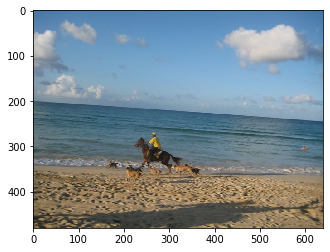


Captions:
x_START_ a man in yellow is riding his horse on the beach x_END_ x_NULL_ x_NULL_ x_NULL_ x_NULL_ 
x_START_ a person riding x_UNK_ on the beach with a x_UNK_ of dogs running along x_END_ x_NULL_ 
x_START_ a man riding on the back of a brown horse on a beach x_END_ x_NULL_ x_NULL_ 
x_START_ a man rides a horse along the beach with a x_UNK_ of dogs x_END_ x_NULL_ x_NULL_ 

Prediction:a bear with multiple trees x_END_ 


In [113]:
testIndex = 457

img = PIL.Image.open(os.path.join(IMAGE_DIR, str(testIndex)))
plt.imshow(img)
plt.show()

print('\nCaptions:')
captions = retreive_capt_id(testIndex, trainImid, trainCap)[0]
for caption in captions:
    capStr = ''
    for word in caption:
        capStr += word_dict[word] + ' '
    print(capStr)
    
embed = np.load(os.path.join(EMBED_DIR, str(testIndex)+'.npy'))
pred = evaluate(embed)
capStr = '\nPrediction:'
for word in pred:
    capStr += word_dict[word] + ' '
print(capStr)

In [118]:
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

encoder.save(os.path.join(MODEL_DIR, 'encoder_attention'))
decoder.save(os.path.join(MODEL_DIR, 'decoder_attention'))

W0111 10:22:27.259610 15596 deprecation.py:506] From c:\users\ayhok\appdata\local\programs\python\python37\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1781: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


TypeError: call() missing 2 required positional arguments: 'features' and 'hidden'